## Variable engineering

 The aim of this challenge is to predict the future numbers of restaurant visitors. This makes it a Time Series Forecasting problem. The data was collected from Japanese restaurants. We have chosen this project, because the data set is small and easily accessible.<br>
 The project is very important and interesting for us because it is a real data set, and real business problem.


In this section, we create new variables.Change their types.Check the relevance of each variable for the future model.<br>
let's try!!!

## Chapters

* 1. [Load Libraries](#load-libraries-cell)
* 2. [Data Wrangling](#data-wrangling-cell)
     * 0 . [Data Aggregation](#data-aggregation-cell)
     * 1 . [Air Visit Data table](#air-visit-cell)
     * 2 . [Air Reserve](#air-reserve-cell)
     * 3 . [Hpg Store Info table](#hpg-store-cell)
 
 
* 3. [Convert the date format and group by date reservation data.](#convert-date-format-cell) 
    * 1.1 [Air Reserve date format](#airres-date-format-cell)
    * 1.2 [Adding new column Air Reserve: air_date_diff](#air-date-diff-cell)
    * 1.3 [Adding new table airMedian](#air-median-cell)
    * 1.4 [Adding new table airres_visit_sum](#airres-visit-sum-cell)
    * 1.5 [Adding new table airresgrupp](#airresgrupp-cell)
    * 2.1 [HPG Reserve date format](#hpgres-date-format-cell)
    * 2.2 [Adding new column Air Reserve: hpg_date_diff](#hpg-date-diff-cell)
    * 2.3 [Adding new table temp1_date_diff_median](#hpg-median-cell)
    * 2.4 [Adding new table temp2_reserve_visitors_sum](#hpgres-visit-sum-cell)
    * 2.5 [Adding new table hpgres_grup](#hpgres-grup-cell)




* 4. [Data aggregation 2](#data-aggregation2-cell)
    * 1.1 [AIR Merge tables airvisit and airresgrupp](#air-new-table-cell)
    * 1.2 [AIRVISSTOR Merge tables air and airstore](#airvisstor-new-table-cell)
    * 1.3 [AIRREL Merge tables airvisstor and rel](#airrel-new-table-cell)
    * 2.1 [HPG Merge tables hpgres_grup and hpgstore](#hpg-new-table-cell)
    * 2.2 [HPGREL Merge tables hpg and rel](#hpgrel-new-table-cell)
    * 3 . [full merge with airrel and hpgres_grup](#full3-cell)
    
    
* 5. [Geography Clustering](#geography-clustering-cell)
    * 1. [KMeans cluster](#kmeans-cell)
            * 1.1 [Full table after cluster](#full-kmeans-cell)
            * 1.2 [Full Graphs (HPG AIR) cluster](#full-graph-cell)
            * 2.1 [Separate the first part of the name of the region](#region1-cell)
            * 2.2 [We calculate what percentage of all restaurants are in each region](#region2-cell)
            * 3 [Explain](#region3-cell)
        


* 6. [Cousine Genres](#cousine-genres-cell)


* 7. [Japanese Holidays and date conversion](#japanese-holidays-cell)

* 8. [Weather Data](#weather-cell)

* 9. [Missing values](#missing-values-cell)

* 10. [Variable selection](#variable-selection-cell)
    * 0. [Graph Variable selection](#graph-variable-selection-cell)
    * 1 . [One Hat Encoding function](#one-hat-code-cell)
           * 1.1 [One Hat Encoding air_genre_name](#genre-name-one-hat-code-cell)
           * 1.2 [One Hat Encoding cluster](#cluster-one-hat-code-cell)
           


## <a id='load-libraries-cell'>0 Load Libraries</a>

In [1]:
# NumPy is a general-purpose array-processing package. 
# It provides a high-performance multidimensional array object, and tools for working with these arrays.
import numpy as np 

# Providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language
import pandas as pd 

from subprocess import check_output 

import matplotlib.pyplot as plt #
import seaborn as sns #

%matplotlib inline 
import matplotlib
matplotlib.style.use('ggplot')

## <a id='data-wrangling-cell'> 1. Data Wrangling</a>

The training data covers the dates from 2016 until April 2017. The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."

##### <a id='data-aggregation-cell'>Data Aggregation</a>

In [2]:
airres = pd.read_csv('../input/air_reserve.csv')
airstore = pd.read_csv('../input/air_store_info.csv')
hpgres = pd.read_csv('../input/hpg_reserve.csv')
hpgstore = pd.read_csv('../input/hpg_store_info.csv')
airvisit = pd.read_csv('../input/air_visit_data.csv')
dates = pd.read_csv('../input/date_info.csv')
wd = pd.read_csv('../input/WeatherData.csv')
rel = pd.read_csv('../input/store_id_relation.csv')
test = pd.read_csv('../input/sample_submission.csv')

<a id='air-visit-cell'>Air Visit Data</a>

In [3]:
airvisit.tail(1)

,air_store_id,visit_date,visitors
252107,air_24e8414b9b07decb,2017-04-22,5


In [4]:
airvisit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


<a id='air-reserve-cell'>Air Reserve</a>

In [5]:
airres.head(1)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1


<a id='hpg-store-cell'>Hpg store info</a>

In [6]:
hpgstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
hpg_store_id      4690 non-null object
hpg_genre_name    4690 non-null object
hpg_area_name     4690 non-null object
latitude          4690 non-null float64
longitude         4690 non-null float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


  ## <a id='convert-date-format-cell'>3. Convert the date format and group by date reservation data. </a>

We want to group reservation data from AIR and HPG by date on which registration was made.As we predict the total number of visitors at a particular time in a particular restaurant.We also calculate the time interval between the date of the order and the date of the visit of the restaurant.

<a id='airres-date-format-cell'>1.1 Air Reserve date format</a>

In [7]:
vdt = pd.to_datetime(airres.visit_datetime)
rdt = pd.to_datetime(airres.reserve_datetime)
airres['visit_date']=vdt.dt.date
airres['rd']=rdt.dt.date

In [8]:
#airres.info()
airres.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,rd
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01


<a id='air-date-diff-cell'>1.2 Adding new column <code>airres</code>: <code>air_date_diff</code></a>

In [9]:
airres['air_date_diff'] = airres.apply(lambda r: (r['visit_date'] - r['rd']).days, axis=1)
airres.head(10)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,rd,air_date_diff
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01,0
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01,0
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01,0
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01,0
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01,0
5,air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 16:00:00,2,2016-01-02,2016-01-01,1
6,air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 15:00:00,4,2016-01-02,2016-01-01,1
7,air_3bb99a1fe0583897,2016-01-02 16:00:00,2016-01-02 14:00:00,2,2016-01-02,2016-01-02,0
8,air_3bb99a1fe0583897,2016-01-02 16:00:00,2016-01-01 20:00:00,2,2016-01-02,2016-01-01,1
9,air_2b8b29ddfd35018e,2016-01-02 17:00:00,2016-01-02 17:00:00,2,2016-01-02,2016-01-02,0


<a id='air-median-cell'>1.3 Adding new table <code>airMedian</code></a>

<p> new table <code>airMedian</code> from <code>airres</code></p>
<p> Grouping <code>air_store_id'</code> and <code>visit_date</code></p>
<p> And by <code>air_date_diff</code> by the help of <code>.median()</code></p>


In [10]:
airMedian = airres.groupby(['air_store_id','visit_date'], as_index=False)['air_date_diff'].median()
#sort_values('mpg',ascending=False)
#airMedian = airMedian.sort_values('visit_date')
airMedian.head()

,air_store_id,visit_date,air_date_diff
0,air_00a91d42b08b08d9,2016-10-31,0.0
1,air_00a91d42b08b08d9,2016-12-05,4.0
2,air_00a91d42b08b08d9,2016-12-14,6.0
3,air_00a91d42b08b08d9,2016-12-17,6.0
4,air_00a91d42b08b08d9,2016-12-20,2.0


<a id='airres-visit-sum-cell'>1.4 Adding new table <code>airres_visit_sum</code></a>

<p> new table <code>airres_visit_sum</code> from <code>airres</code></p>
<p> Grouping <code>air_store_id</code> and <code>visit_date</code></p>
<p> And by <code>reserve_visitors</code> by the help of <code>.sum()</code></p>
<p> And rename this column to <code>reserve_visitors_air</code></p>

In [11]:
airres_visit_sum = airres.groupby(['air_store_id','visit_date'], as_index=False)['reserve_visitors'].sum().rename(
    columns={'reserve_visitors': 'reserve_visitors_air'})
#airres_visit_sum =  airres_visit_sum.sort_values('visit_date')
airres_visit_sum.head()

,air_store_id,visit_date,reserve_visitors_air
0,air_00a91d42b08b08d9,2016-10-31,2
1,air_00a91d42b08b08d9,2016-12-05,9
2,air_00a91d42b08b08d9,2016-12-14,18
3,air_00a91d42b08b08d9,2016-12-17,2
4,air_00a91d42b08b08d9,2016-12-20,4


<a id='airresgrupp-cell'>1.5 Adding new table <code>airresgrupp</code></a>

<p> new table <code>airresgrupp</code> from <code>airres_visit_sum</code> and <code>airMedian</code></p>
<p> Merging the 2 tables and by the keys of <code>air_store_id</code> and <code>visit_date</code></p>
<p> The columns we now have <code>air_store_id</code>,<code>visit_date</code>,<code>reserve_visitors_air</code>,<code>air_date_diff</code></p>
<p> the table len is 29830</p>

In [12]:
airresgrupp = pd.merge(airres_visit_sum,airMedian,how='left',on=['air_store_id','visit_date'])
airresgrupp.head(20)

,air_store_id,visit_date,reserve_visitors_air,air_date_diff
0,air_00a91d42b08b08d9,2016-10-31,2,0.0
1,air_00a91d42b08b08d9,2016-12-05,9,4.0
2,air_00a91d42b08b08d9,2016-12-14,18,6.0
3,air_00a91d42b08b08d9,2016-12-17,2,6.0
4,air_00a91d42b08b08d9,2016-12-20,4,2.0
5,air_00a91d42b08b08d9,2017-02-18,9,5.0
6,air_00a91d42b08b08d9,2017-02-23,12,2.0
7,air_00a91d42b08b08d9,2017-03-01,3,11.0
8,air_00a91d42b08b08d9,2017-03-14,4,0.0
9,air_00a91d42b08b08d9,2017-03-21,3,5.0


In [13]:
airresgrupp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29830 entries, 0 to 29829
Data columns (total 4 columns):
air_store_id            29830 non-null object
visit_date              29830 non-null object
reserve_visitors_air    29830 non-null int64
air_date_diff           29830 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


<a id='hpgres-date-format-cell'>2.1 HPG Reserve date format</a>

In [14]:
# HPG
vdt = pd.to_datetime(hpgres.visit_datetime)
rdt = pd.to_datetime(hpgres.reserve_datetime)
hpgres['visit_date'] = vdt.dt.date
hpgres['rd'] = rdt.dt.date
hpgres.head(1)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,rd
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,2016-01-01


In [15]:
hpgres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 6 columns):
hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors    int64
visit_date          object
rd                  object
dtypes: int64(1), object(5)
memory usage: 91.6+ MB


<a id='hpg-date-diff-cell'>2.2 Adding new column <code>hpgres</code>: <code>hpg_date_diff</code></a>

In [16]:
hpgres['hpg_date_diff'] = hpgres.apply(lambda r: (r['visit_date'] - r['rd']).days, axis=1)

<a id='hpg-median-cell'>2.3 Adding new table <code>temp1_date_diff_median</code></a>

<p> new table <code>temp1_date_diff_median</code> from <code>hpgres</code></p>
<p> Grouping <code>hpg_store_id'</code> and <code>visit_date</code></p>
<p> And by <code>hpg_date_diff</code> by the help of <code>.median()</code></p>

In [17]:
#hpgres = hpgres.groupby(['hpg_store_id','vd'], as_index=False)[['date_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})
temp1_date_diff_median = hpgres.groupby(['hpg_store_id','visit_date'], as_index=False)['hpg_date_diff'].median()
#temp1_date_diff_median = temp1_date_diff_median.sort_values('visit_date')
#temp1_date_diff_median.head(30)

In [18]:
temp1_date_diff_median.head()

,hpg_store_id,visit_date,hpg_date_diff
0,hpg_001112ef76b9802c,2016-02-26,17.0
1,hpg_001112ef76b9802c,2016-03-17,14.0
2,hpg_001112ef76b9802c,2016-03-31,6.0
3,hpg_001112ef76b9802c,2016-04-05,4.0
4,hpg_001112ef76b9802c,2016-04-18,3.0


In [19]:
#temp1_date_diff_median.info()
temp1_date_diff_median.describe()

,hpg_date_diff
count,1.355053e+06
mean,7.003639e+00
std,8.001880e+00
min,0.000000e+00
25%,2.000000e+00
50%,4.000000e+00
75%,9.000000e+00
max,3.680000e+02


<a id='hpgres-visit-sum-cell'>2.4 Adding new table <code>temp2_reserve_visitors_sum</code></a>

<p> new table <code>temp2_reserve_visitors_sum</code> from <code>hpgres</code></p>
<p> Grouping <code>air_store_id</code> and <code>visit_date</code></p>
<p> And by <code>reserve_visitors</code> by the help of <code>.sum()</code></p>
<p> And rename this column to <code>reserve_visitors_hpg</code></p>

In [20]:
#hpgres = hpgres.groupby(['hpg_store_id','vd'], as_index=False)[['date_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})
#temp1_date_diff_median = hpgres.groupby(['hpg_store_id','visit_date'], as_index=False)['hpg_date_diff'].median()
temp2_reserve_visitors_sum = hpgres.groupby(['hpg_store_id','visit_date'], as_index=False)\
['reserve_visitors'].sum().rename(
    columns={'reserve_visitors': 'reserve_visitors_hpg'})
#temp2_reserve_visitors_sum = temp2_reserve_visitors_sum.sort_values('visit_date')

<a id='hpgres-grup-cell'>2.5 Adding new table <code>hpgres_grup</code></a>

<p> new table <code>hpgres_grup</code> from <code>temp2_reserve_visitors_sum</code> and <code>temp1_date_diff_median</code></p>
<p> Merging the 2 tables and by the keys of <code>hpg_store_id</code> and <code>visit_date</code></p>
<p> The columns we now have <code>hpg_store_id</code>,<code>visit_date</code>,<code>reserve_visitors_hpg</code>,<code>hpg_date_diff</code></p>
<p> the table len is 29830</p>

In [21]:
hpgres_grup = pd.merge(temp2_reserve_visitors_sum ,temp1_date_diff_median,how='left',on=['hpg_store_id','visit_date'])
hpgres_grup.head(20)

,hpg_store_id,visit_date,reserve_visitors_hpg,hpg_date_diff
0,hpg_001112ef76b9802c,2016-02-26,9,17.0
1,hpg_001112ef76b9802c,2016-03-17,3,14.0
2,hpg_001112ef76b9802c,2016-03-31,5,6.0
3,hpg_001112ef76b9802c,2016-04-05,13,4.0
4,hpg_001112ef76b9802c,2016-04-18,9,3.0
5,hpg_001112ef76b9802c,2016-07-05,3,11.0
6,hpg_001112ef76b9802c,2016-07-14,5,6.0
7,hpg_001112ef76b9802c,2016-07-21,3,27.0
8,hpg_001112ef76b9802c,2016-07-26,3,32.0
9,hpg_001112ef76b9802c,2016-07-28,3,29.0


After each section we check that there are no null values

## <a id='data-aggregation2-cell'>4. Data aggregation 2</a>

In [22]:
# Format the datetime airvisit and airresgrupp
airvisit['visit_date'] = pd.to_datetime(airvisit['visit_date'])
airresgrupp['visit_date'] = pd.to_datetime(airresgrupp['visit_date'])

In [23]:
#airvisit.head(10)

In [24]:
airresgrupp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29830 entries, 0 to 29829
Data columns (total 4 columns):
air_store_id            29830 non-null object
visit_date              29830 non-null datetime64[ns]
reserve_visitors_air    29830 non-null int64
air_date_diff           29830 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB


<a id='air-new-table-cell'>1.1 air Merge tables <code>airvisit</code> and <code>airresgrupp</code></a>

In [25]:
air= pd.merge(airvisit,airresgrupp,how='left',on=['air_store_id','visit_date'])

In [26]:
#air.describe()
air.info()
#252108 - 28064

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 5 columns):
air_store_id            252108 non-null object
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 11.5+ MB


<a id='airvisstor-new-table-cell'>1.2 <code>airvisstor</code> Merge tables <code>air</code> and <code>airstore</code></a>

In [27]:
airvisstor = pd.merge(air,airstore,on='air_store_id')

In [28]:
airvisstor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 9 columns):
air_store_id            252108 non-null object
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
air_genre_name          252108 non-null object
air_area_name           252108 non-null object
latitude                252108 non-null float64
longitude               252108 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 19.2+ MB


<a id='airrel-new-table-cell'>1.3 <code>airrel</code> Merge tables <code>airvisstor</code> and <code>rel</code></a>

In [29]:
airrel = pd.merge(airvisstor,rel,how='left',on='air_store_id')
airrel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 10 columns):
air_store_id            252108 non-null object
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
air_genre_name          252108 non-null object
air_area_name           252108 non-null object
latitude                252108 non-null float64
longitude               252108 non-null float64
hpg_store_id            46019 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 21.2+ MB


<a id='hpg-new-table-cell'>2.1 <code>hpg</code> Merge tables <code>hpgres_grup</code> and <code>hpgstore</code></a>

In [30]:
hpg = pd.merge(hpgres_grup,hpgstore,on='hpg_store_id')
hpg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561109 entries, 0 to 561108
Data columns (total 8 columns):
hpg_store_id            561109 non-null object
visit_date              561109 non-null object
reserve_visitors_hpg    561109 non-null int64
hpg_date_diff           561109 non-null float64
hpg_genre_name          561109 non-null object
hpg_area_name           561109 non-null object
latitude                561109 non-null float64
longitude               561109 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 38.5+ MB


<a id='hpgrel-new-table-cell'>2.2 <code>hpgrel</code> Merge tables <code>hpg</code> and <code>rel</code></a>

In [31]:
hpgrel = pd.merge(hpg,rel,how='left',on=['hpg_store_id'])
hpgrel.info()
#hh = pd.merge(rel,how='left',on=['hpg_store_id','air_store_id'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561109 entries, 0 to 561108
Data columns (total 9 columns):
hpg_store_id            561109 non-null object
visit_date              561109 non-null object
reserve_visitors_hpg    561109 non-null int64
hpg_date_diff           561109 non-null float64
hpg_genre_name          561109 non-null object
hpg_area_name           561109 non-null object
latitude                561109 non-null float64
longitude               561109 non-null float64
air_store_id            8877 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 42.8+ MB


In [32]:
# Format the datetime airvisit and airresgrupp
airrel['visit_date'] = pd.to_datetime(airrel['visit_date'])
hpgres_grup['visit_date'] = pd.to_datetime(hpgres_grup['visit_date'])

<a id='full3-cell'>3. <code>full</code>merge with <code>airrel</code> and <code>hpgres_grup</code></a>

In [33]:
full = pd.merge(airrel,hpgres_grup, how = 'left', on = ['hpg_store_id','visit_date'])
print("there are ",len(air)," restaurants with AIR and ",len(hpg)," with HPG.",len(rel),' have both.')

there are  252108  restaurants with AIR and  561109  with HPG. 150  have both.


In [34]:
full.head()

,air_store_id,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,reserve_visitors_hpg,hpg_date_diff
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN


In [35]:
#full.drop(['visit_date_y'], axis=1, inplace=True)
full.columns

Index(['air_store_id', 'visit_date', 'visitors', 'reserve_visitors_air',
       'air_date_diff', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'hpg_store_id', 'reserve_visitors_hpg', 'hpg_date_diff'],
      dtype='object')

In [36]:
#full['visit_date']=full['visit_date_x']
#full.drop(['visit_date_x'], axis=1, inplace=True)

In [37]:
#full.info()
len(full['air_store_id'].unique())

829

In this step, we see that there are very few intersections in the two systems AIR and HPG.

Missing Values Now we can start the analysis by looking at the percentage of missing values in each column. Missing values are fine when we do Exploratory Data Analysis, but they will have to be filled in for machine learning methods.  Following is a function that calculates the number of missing values and the percentage of the total values that are missing for each column. As with many tasks in data science, I did not write this function myself, but rather found it online in a Stack Overflow forum!

## <a id='geography-clustering-cell'>5 Geography Clustering</a>

Apparently Japan's terittory is divided in 8 regions which are not official administrative units, but have been traditionally used as the regional division of Japan in a number of contexts [https://en.wikipedia.org/wiki/List_of_regions_of_Japan ]

From north to south, the traditional regions are:
* **Hokkaidō** (the island of Hokkaidō and nearby islands, population: 5,507,456, largest city: Sapporo)
* **Tōhoku** region (northern Honshū, population: 9,335,088, largest city: Sendai)
* **Kantō** region (eastern Honshū, population: 42,607,376, largest city: Tokyo)
* **Chūbu region** (central Honshū, including Mt. Fuji, population: 21,714,995, largest city: Nagoya), sometimes divided into:
   * Hokuriku region (northwestern Chūbu, largest city: Kanazawa)
   * Kōshin'etsu region (northeastern Chūbu, largest city: Niigata)
  * Tōkai region (southern Chūbu, largest city: Nagoya)
* **Kansai or Kinki** region (west-central Honshū, including the old capital, Kyoto, population: 22,755,030, largest city: Osaka)
* **Chūgoku** region (western Honshū, population: 7,561,899, largest city: Hiroshima)
* **Shikoku** (island, population: 3,977,205, largest city: Matsuyama)
* **Kyūshū** (island, population: 14,596,977, largest city: Fukuoka) which includes:
  * Northern Kyushu: Fukuoka, Saga, Nagasaki and Ōita (largest city: Fukuoka)
  * Southern Kyushu: Kumamoto, Miyazaki and Kagoshima (largest city: Kagoshima)
  * Okinawa (largest city: Naha)

##### <a id='kmeans-cell'>KMeans cluster</a>

<p>Having new column to table <code>full</code></p>
<p><code>cluster</code> : we do cluster analysis by geographic position(Longitude,Latitude)</p>
<p>the number of classes is equal to 9 because in Japan there are 9 areas(n_clusters=8)</p>

In [38]:
#we do cluster analysis by geographic position(Longitude,Latitude)
#the number of classes is equal to 9 because in Japan there are 9 areas(n_clusters=8)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(full[['longitude','latitude']])
full['cluster'] = kmeans.predict(full[['longitude','latitude']])

<a id='full-kmeans-cell'> 1.1 <code>full</code> table after cluster</a>

<p> The columns that now we have are:</p>
<p><code>air_store_id</code>, <code>visit_date</code>, <code>visitors</code>, <code>reserve_visitors_air</code></p>	
<p><code>air_date_diff</code>,<code>air_genre_name</code>, <code>air_area_name</code>,</p>
<p><code>latitude</code>,<code>longitude</code>, <code>hpg_store_id</code>,<code>reserve_visitors_hpg</code>,</p>
<p><code>hpg_date_diff</code>,<code>cluster</code>.</p>

In [39]:
full.head()

,air_store_id,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,cluster
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0


<a id='full-graph-cell'> 1.2 <code>full</code> Graphs (HPG AIR) <code>cluster</code></a>

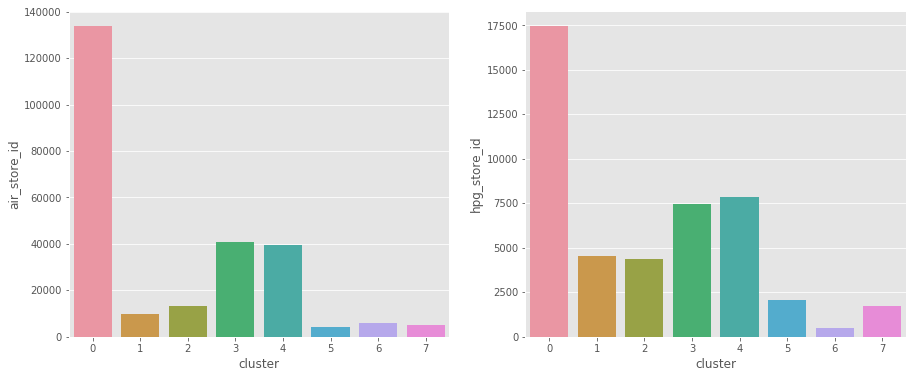

In [40]:
f,axa = plt.subplots(1,2,figsize=(15,6))
hist_clust = full.groupby(['cluster'],as_index=False).count()
sns.barplot(x=hist_clust.cluster,y=hist_clust.air_store_id,ax=axa[0])
sns.barplot(x=hist_clust.cluster,y=hist_clust.hpg_store_id,ax=axa[1])
plt.show()

In [41]:
#we import the library "Basemap" from mpl_toolkits.basemap and projection to create a map
#import os
#os.environ["PROJ_LIB"] = "C:\\Users\\sergey\\Anaconda3\\Library\\share";
#from mpl_toolkits.basemap import Basemap

In [42]:
#m = Basemap(projection='aeqd',width=2000000,height=2000000, lat_0=37.5, lon_0=138.2)

In [43]:
#cx = [c[0] for c in kmeans.cluster_centers_]
#cy = [c[1] for c in kmeans.cluster_centers_]
#cm = plt.get_cmap('gist_rainbow')

#colors = [cm(2.*i/10) for i in range(10)]
#colored = [colors[k] for k in full['cluster']]
#f,axa = plt.subplots(1,1,figsize=(22,48))

#m.shadedrelief()
#m.drawcoastlines()
#m.fillcontinents(color='lightyellow',lake_color='aqua',zorder=1)
#m.drawcoastlines()
#m.drawcountries(linewidth = 3)
#m.drawstates(color='0.3')
#parallels = np.arange(0.,360,10.,)
#m.drawparallels(parallels, labels = [True for s in range(len(parallels))])
#meridians = np.arange(0.,360,10.,)

#m.scatter(full.longitude.values,full.latitude.values,color=colored,s=20,alpha=1,zorder=999,latlon=True)
#m.scatter(df_full.longitude.values,df_full.latitude.values,color=colored,s=20,alpha=1,zorder=999,latlon=True)
#m.scatter(cx,cy,color='Black',s=50,alpha=1,latlon=True,zorder=999)
#plt.setp(axa.get_yticklabels(), visible=True)
#plt.annotate('Fukuoka', xy=(0.04, 0.32), xycoords='axes fraction',fontsize=20)
#plt.annotate('Shikoku', xy=(0.25, 0.25), xycoords='axes fraction',fontsize=20)
#plt.annotate('Hiroshima', xy=(0.2, 0.36), xycoords='axes fraction',fontsize=20)
#plt.annotate('Osaka', xy=(0.40, 0.32), xycoords='axes fraction',fontsize=20)
#plt.annotate('Tokyo', xy=(0.60, 0.4), xycoords='axes fraction',fontsize=20)
#plt.annotate('Shizuoka', xy=(0.50, 0.32), xycoords='axes fraction',fontsize=20)
#plt.annotate('Niigata', xy=(0.48, 0.54), xycoords='axes fraction',fontsize=20)
#plt.annotate('Fukushima', xy=(0.62, 0.54), xycoords='axes fraction',fontsize=20)
#plt.annotate('Hokkaido', xy=(0.7, 0.74), xycoords='axes fraction',fontsize=20)
#plt.annotate('Hyogo', xy=(0.34, 0.30), xycoords='axes fraction',fontsize=20)

#for i in range(len(cx)):
 #   xpt,ypt = m(cx[i],cy[i])
 #   plt.annotate(i, (xpt+500,ypt+500),zorder=99999,fontsize=16)
 #   plt.title("Map of cluster distribution",fontsize=25)
#plt.show()

On the map we can see by the color of the points that the classes are rightly spread out and distributed around the black points.<br>
Now we check which class number is equal to which region.

<a id='region1-cell'> 2.1 separate the first part of the name of the region</a>

<p>separate the first part of the name of the region</p>

In [44]:
full['prefecture'] = full['air_area_name'].map(lambda x: str(x).split(' ')[0])
full.head(1)

,air_store_id,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,reserve_visitors_hpg,hpg_date_diff,cluster,prefecture
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,Tōkyō-to


<a id='region2-cell'> 2.2 we calculate what percentage of all restaurants are in each region</a>

<p>we calculate what percentage of all restaurants are in each region</p>

In [45]:
aircluster = full.groupby(['prefecture','cluster',], as_index=False)['air_store_id'].count()
aircluster['percent'] = aircluster.air_store_id/aircluster.air_store_id.sum()*100
aircluster.head()

,prefecture,cluster,air_store_id,percent
0,Fukuoka-ken,4,39645,15.725403
1,Hiroshima-ken,1,9858,3.910229
2,Hokkaidō,2,13055,5.178336
3,Hyōgo-ken,3,17846,7.078712
4,Miyagi-ken,6,5959,2.363670


<p><code>prefecture</code></p>
<p><code>cluster</code></p>
<p><code>air_store_id</code></p>
<p><code>percent</code></p>

<a id='region3-cell'>3. Explain</a>

Let's try to relate the identified groups with the biggest cities:

* Cluster 1 refers to Hiroshima-ken.
* Cluster 5 refers  to Niigata-ken
* Cluster 2 refers to Hokkaidō
* Cluster 0 refers to Tōkyō-to
* Cluster 3 refers to Hyōgo-ken
* Cluster 4 referst to Fukuoka-ken
* Cluster 7 refers to Shizuoka-ken
* Cluster 6 refers to Miyagi-ken

In [46]:
aircluster.air_store_id.sum()

252108

## <a id='cousine-genres-cell'>Cousine Genres</a>

Now let's check out wht are the genres appreciated in Japan. I have prepared two heatmaps: the former with thenumber of restaurants for each genre (columns) in each region (row) for thos with AIR reservation system; the latter with the HPG.
We are very interested in popularity by region and by genre.<br>
These are the main factors determining the choice!

In [47]:
air.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 5 columns):
air_store_id            252108 non-null object
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 11.5+ MB


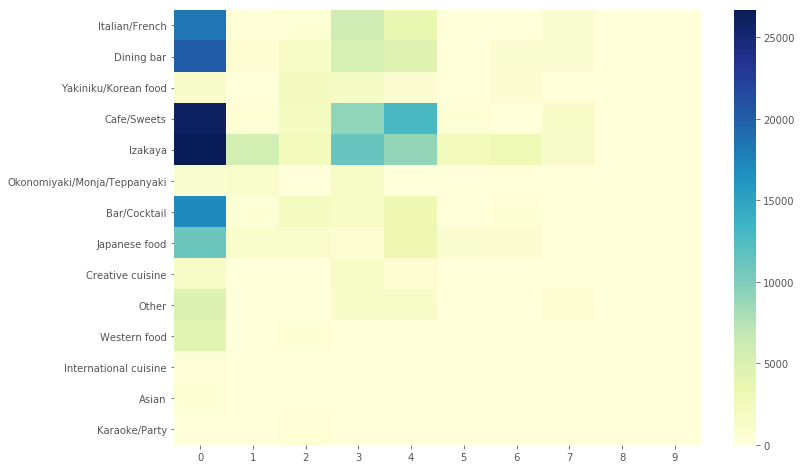

In [48]:
air_genre = full.loc[full.air_genre_name.isnull()==False].groupby(['cluster','air_genre_name'],as_index=False).count()
genres = airstore['air_genre_name'].unique()

#i = 0
fig=plt.figure(figsize=(26,8))
ax2 = fig.add_subplot(122)
hm = []
for i in range(10):
    genres_count = [ air_genre.loc[air_genre.cluster==i].loc[air_genre.air_genre_name==name]['air_store_id'].values[0] if name in air_genre.loc[air_genre.cluster==i].air_genre_name.values else 0 for name in genres] 
    hm.append(genres_count)
hm = pd.DataFrame(hm,columns=genres,)
sns.heatmap(hm.transpose(),cmap="YlGnBu",ax=ax2)

plt.show()

From the resulting heat map we see that the most popular region is number "3"- Tōkyō-to and genre "Italian\French". <br>
Also we cen see that the in other region the most popula genre is "Izakaya". An izakaya (居酒屋) is a type of informal Japanese pub. They are casual places for after-work drinking. They have been compared to Irish pubs, tapas bars and early American saloons and taverns.

## <a id='japanese-holidays-cell'>Japanese Holidays and date conversion</a>

  At the stage ofdata analysis(EDA), we see that one of the important factors affecting the attendance of restaurants are day of the week, month and holidays.

I want to learn more about that so I will rely on this list https://www.officeholidays.com/countries/japan/index.php

* Jan 1st - **New Years day**;
* 2nd Monday of January - **Coming of Age day **: The day honors young Japanese who will reach the age of 20 at any point during the year. Twenty is the age of majority in Japan, and people who have reached this age gain the right to vote in elections as well as to drink;
* Feb 11th - **National Foundation day**:  a national holiday for Japanese people to remind themselves of the nation's founding and foster their love for the nation;
* March 20th or 21st- **Vernal Equinox day**: The day is intended to celebrate the love of nature and living things.In modern Japan, the day still maintains its older traditions as visiting family graves and holding family reunions is a common way of celebrating the equinox;
* April 29th - ** Showa day**: Showa Day honours the birthday of Emperor Hirohito, the reigning Emperor before, during, and after World War II (from 1926 - 1989);

In [49]:
dates['visit_date']=dates['calendar_date']
dates.head(3)

,calendar_date,day_of_week,holiday_flg,visit_date
0,2016-01-01,Friday,1,2016-01-01
1,2016-01-02,Saturday,1,2016-01-02
2,2016-01-03,Sunday,1,2016-01-03


In [50]:
dates.drop(['calendar_date'], axis=1, inplace=True)

In [51]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 14 columns):
air_store_id            252108 non-null object
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
air_genre_name          252108 non-null object
air_area_name           252108 non-null object
latitude                252108 non-null float64
longitude               252108 non-null float64
hpg_store_id            46019 non-null object
reserve_visitors_hpg    13550 non-null float64
hpg_date_diff           13550 non-null float64
cluster                 252108 non-null int32
prefecture              252108 non-null object
dtypes: datetime64[ns](1), float64(6), int32(1), int64(1), object(5)
memory usage: 27.9+ MB


In [52]:
full.columns

Index(['air_store_id', 'visit_date', 'visitors', 'reserve_visitors_air',
       'air_date_diff', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'hpg_store_id', 'reserve_visitors_hpg', 'hpg_date_diff',
       'cluster', 'prefecture'],
      dtype='object')

In [53]:
full.drop(['hpg_store_id','hpg_date_diff','air_area_name',], axis=1, inplace=True)

In [54]:
full['visit_date'] = pd.to_datetime(full['visit_date'])

In [55]:
full.columns

Index(['air_store_id', 'visit_date', 'visitors', 'reserve_visitors_air',
       'air_date_diff', 'air_genre_name', 'latitude', 'longitude',
       'reserve_visitors_hpg', 'cluster', 'prefecture'],
      dtype='object')

In [56]:
full['month'] = full['visit_date'].dt.month 
full['date'] = full['visit_date'].dt.day
full['dw'] = full['visit_date'].dt.dayofweek
full['dy'] = full['visit_date'].dt.dayofyear
full.head()

,air_store_id,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,latitude,longitude,reserve_visitors_hpg,cluster,prefecture,month,date,dw,dy
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,13,2,13
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,14,3,14
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,15,4,15
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,16,5,16
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,18,0,18


In [57]:
full.columns

Index(['air_store_id', 'visit_date', 'visitors', 'reserve_visitors_air',
       'air_date_diff', 'air_genre_name', 'latitude', 'longitude',
       'reserve_visitors_hpg', 'cluster', 'prefecture', 'month', 'date', 'dw',
       'dy'],
      dtype='object')

In [58]:
dates['visit_date'] = pd.to_datetime(dates['visit_date'])
full['visit_date'] = pd.to_datetime(full['visit_date'])

In [59]:
full.columns

Index(['air_store_id', 'visit_date', 'visitors', 'reserve_visitors_air',
       'air_date_diff', 'air_genre_name', 'latitude', 'longitude',
       'reserve_visitors_hpg', 'cluster', 'prefecture', 'month', 'date', 'dw',
       'dy'],
      dtype='object')

In [60]:
nf = pd.merge(full, dates, how='left', on=['visit_date']) 
nf.head()

,air_store_id,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,latitude,longitude,reserve_visitors_hpg,cluster,prefecture,month,date,dw,dy,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,13,2,13,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,14,3,14,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,15,4,15,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,16,5,16,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,18,0,18,Monday,0


In [61]:
nf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 17 columns):
air_store_id            252108 non-null object
visit_date              252108 non-null datetime64[ns]
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
air_genre_name          252108 non-null object
latitude                252108 non-null float64
longitude               252108 non-null float64
reserve_visitors_hpg    13550 non-null float64
cluster                 252108 non-null int32
prefecture              252108 non-null object
month                   252108 non-null int64
date                    252108 non-null int64
dw                      252108 non-null int64
dy                      252108 non-null int64
day_of_week             252108 non-null object
holiday_flg             252108 non-null int64
dtypes: datetime64[ns](1), float64(5), int32(1), int64(6), object(4)
memory usage: 33.7

In [62]:
#nf.to_csv(r'C:\Users\sergey\Documents\Recruit Restaurant Visitor_2\nf.csv')
nf.columns

Index(['air_store_id', 'visit_date', 'visitors', 'reserve_visitors_air',
       'air_date_diff', 'air_genre_name', 'latitude', 'longitude',
       'reserve_visitors_hpg', 'cluster', 'prefecture', 'month', 'date', 'dw',
       'dy', 'day_of_week', 'holiday_flg'],
      dtype='object')

In [63]:
#we assign indexes for holiday, sunday, saturday.
nf['sunday'] = nf['visit_date'].dt.dayofweek.apply(lambda x:1 if x==6 else 0)
nf['saturday'] = nf['visit_date'].dt.dayofweek.apply(lambda x:1 if x==5 else 0)
nf['sat/sun/hol']=nf['holiday_flg']*1+nf['sunday']*0.5+nf['saturday']*0.3

nf2016 = nf[nf['visit_date'].dt.year==2016]
nf2017 = nf[nf['visit_date'].dt.year==2017]
nf.head()

,air_store_id,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,latitude,longitude,reserve_visitors_hpg,cluster,prefecture,month,date,dw,dy,day_of_week,holiday_flg,sunday,saturday,sat/sun/hol
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,13,2,13,Wednesday,0,0,0,0.0
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,14,3,14,Thursday,0,0,0,0.0
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,15,4,15,Friday,0,0,0,0.0
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,16,5,16,Saturday,0,0,1,0.3
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,18,0,18,Monday,0,0,0,0.0


We can check how many days before the visit japenese people make the reservation.

In [64]:
nf.air_date_diff.describe()

count    28064.000000
mean         5.043561
std          8.534882
min          0.000000
25%          0.500000
50%          2.000000
75%          6.000000
max        349.500000
Name: air_date_diff, dtype: float64

## <a id='weather-cell'>5. Weather Data</a>

In [65]:
wd.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,1/2/16,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,1/3/16,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,1/4/16,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,1/5/16,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [66]:
#separate the first part of the name of the region
wd['prefecture'] = wd['area_name'].map(lambda x: str(x).split('_')[0])
wd.head(1)

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,prefecture
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1,fukuoka


In [67]:
wdmytest = wd.groupby(['prefecture'], as_index=False)['avg_temperature'].mean()
wdmytest.head(15)

,prefecture,avg_temperature
0,fukuoka,15.728844
1,hiroshima,14.317344
2,hokkaido,5.872029
3,hyogo,14.592747
4,kanagawa,15.356673
5,miyagi,11.087105
6,niigata,12.433745
7,osaka,14.812773
8,saitama,13.533269
9,shizuoka,15.470068


Let's try to relate the identified groups with the biggest cities:

* Cluster 1 refers to Hiroshima-ken.
* Cluster 5 refers  to Niigata-ken
* Cluster 2 refers to Hokkaidō
* Cluster 0 refers to Tōkyō-to
* Cluster 3 refers to Hyōgo-ken
* Cluster 4 referst to Fukuoka-ken
* Cluster 7 refers to Shizuoka-ken
* Cluster 6 refers to Miyagi-ken

In [68]:
import re
def area2group(area):
    if re.match(r'tokyo.*',area) !=None:
        return 0
    if re.match(r'hyogo.*',area) !=None:
        return 3
    if re.match(r'hokkaido.*',area) !=None:
        return 2    
    if re.match(r'fukuoka.*',area) !=None:
        return 4
    if re.match(r'niigata.*',area) !=None:
        return 5
    if re.match(r'hiroshima.*',area) !=None:
        return 1
    if re.match(r'shizuoka.*',area) !=None:
        return 7
    if re.match(r'miyagi.*',area) !=None:
        return 6
    else:
        return -1

warea = [area2group(area) for area in wd.area_name]
wd['cluster'] = warea
#re.match(r'fukuoka.*',wd.area_name[0])
#wd.area_name

In [69]:
wd['calendar_date'] = pd.to_datetime(wd.calendar_date).dt.date
wd.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,prefecture,cluster
0,fukuoka_dazaifu-kana_dasaif,2016-01-01,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1,fukuoka,4
1,fukuoka_dazaifu-kana_dasaif,2016-01-02,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1,fukuoka,4
2,fukuoka_dazaifu-kana_dasaif,2016-01-03,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1,fukuoka,4
3,fukuoka_dazaifu-kana_dasaif,2016-01-04,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9,fukuoka,4
4,fukuoka_dazaifu-kana_dasaif,2016-01-05,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1,fukuoka,4


In [70]:
wdg = wd.groupby(['cluster','calendar_date'],as_index=False).mean()
wdg.head()

,cluster,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,-1,2016-01-01,0.0,6.36,NaN,NaN,8.4125,2.09,5.966667,55.333333,1028.500000,1022.500000,11.215,2.833333,11.13,2.35
1,-1,2016-01-02,0.0,7.46,NaN,NaN,5.6250,1.78,7.366667,62.666667,1024.100000,1018.166667,7.080,6.433333,13.02,2.44
2,-1,2016-01-03,0.0,9.84,NaN,NaN,6.0125,1.52,9.533333,71.000000,1018.500000,1012.600000,8.080,6.266667,15.52,5.91
3,-1,2016-01-04,0.0,10.08,NaN,NaN,6.7250,2.06,9.033333,66.333333,1017.433333,1011.533333,9.305,1.600000,15.13,5.07
4,-1,2016-01-05,0.0,9.01,NaN,NaN,3.1750,1.74,7.866667,62.333333,1020.200000,1014.333333,3.080,6.433333,12.27,5.57


In [71]:
nf.head()

,air_store_id,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,latitude,longitude,reserve_visitors_hpg,cluster,prefecture,month,date,dw,dy,day_of_week,holiday_flg,sunday,saturday,sat/sun/hol
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,13,2,13,Wednesday,0,0,0,0.0
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,14,3,14,Thursday,0,0,0,0.0
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,15,4,15,Friday,0,0,0,0.0
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,16,5,16,Saturday,0,0,1,0.3
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,18,0,18,Monday,0,0,0,0.0


In [72]:
nf['visit_date']=pd.to_datetime(nf.visit_date).dt.date
nf.head(1)

,air_store_id,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,latitude,longitude,reserve_visitors_hpg,cluster,prefecture,month,date,dw,dy,day_of_week,holiday_flg,sunday,saturday,sat/sun/hol
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,Tōkyō-to,1,13,2,13,Wednesday,0,0,0,0.0


In [73]:
wnf = pd.merge(nf,wdg,left_on=['cluster','visit_date'], right_on=['cluster','calendar_date'])
#wnf = pd.merge(wdg,nf,left_on=['cluster','calendar_date'],right_on=['cluster','visit_date'])
wnf.head()

,air_store_id,visit_date,visitors,reserve_visitors_air,air_date_diff,air_genre_name,latitude,longitude,reserve_visitors_hpg,cluster,...,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,...,8.833333,1.514286,4.9,60.0,1013.1,1010.1,10.86,2.5,9.171429,-2.028571
1,air_25e9888d30b386df,2016-01-13,21,NaN,NaN,Izakaya,35.626568,139.725858,NaN,0,...,8.833333,1.514286,4.9,60.0,1013.1,1010.1,10.86,2.5,9.171429,-2.028571
2,air_fd6aac1043520e83,2016-01-13,40,NaN,NaN,Izakaya,35.658068,139.751599,NaN,0,...,8.833333,1.514286,4.9,60.0,1013.1,1010.1,10.86,2.5,9.171429,-2.028571
3,air_64d4491ad8cdb1c6,2016-01-13,5,NaN,NaN,Dining bar,35.658068,139.751599,NaN,0,...,8.833333,1.514286,4.9,60.0,1013.1,1010.1,10.86,2.5,9.171429,-2.028571
4,air_5c65468938c07fa5,2016-01-13,16,NaN,NaN,Other,35.661777,139.704051,NaN,0,...,8.833333,1.514286,4.9,60.0,1013.1,1010.1,10.86,2.5,9.171429,-2.028571


### <a id='missing-values-cell'>6. Missing values</a>

In [74]:
wnf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 35 columns):
air_store_id            252108 non-null object
visit_date              252108 non-null object
visitors                252108 non-null int64
reserve_visitors_air    28064 non-null float64
air_date_diff           28064 non-null float64
air_genre_name          252108 non-null object
latitude                252108 non-null float64
longitude               252108 non-null float64
reserve_visitors_hpg    13550 non-null float64
cluster                 252108 non-null int32
prefecture              252108 non-null object
month                   252108 non-null int64
date                    252108 non-null int64
dw                      252108 non-null int64
dy                      252108 non-null int64
day_of_week             252108 non-null object
holiday_flg             252108 non-null int64
sunday                  252108 non-null int64
saturday                252108 non-null int64
sat

We can see that there are two columns in which there are zero values: "Total snowfall" and "Deepest snowfall".
It's snowing in japan only in winter.This is less than half of our data.We also make a forecast for the spring.

We decided to delete the following columns

## <a id='variable-selection-cell'> 7. Variable selection</a>

<a id='graph-variable-selection-cell'>0. Graph Variable selection</a>

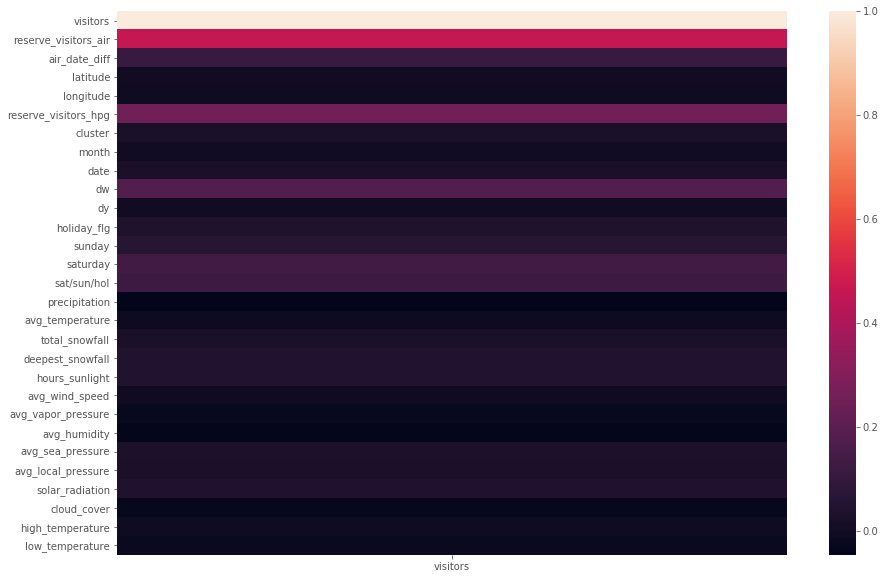

In [75]:
f,axa = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(wnf.corr()[['visitors']])

Apparently there number of visitors is not correlated with the weather conditions

<a id='one-hat-code-cell'> 1.One Hat Encoding function</a>

In [76]:
def our_hat_code(myData, colQuery):
    temp = list(myData[colQuery].unique())
    print(temp)
    n = len(temp) 
    print(n)
    for ii in range(0,n):
        #print('test')
        #print("1",myData[ii])
        #print("2",myData[temp[ii]])
        myData[temp[ii]] = None
        myData.loc[(myData[colQuery] == temp[ii] ),temp[ii]] = 1
        myData.loc[(myData[colQuery] != temp[ii]),temp[ii]] = 0

In [77]:
copyTest = wnf.copy()

<a id='genre-name-one-hat-code-cell'> 1.1. One Hat Encoding <code>air_genre_name</code></a>

In [78]:
our_hat_code(copyTest,'air_genre_name')

['Dining bar', 'Izakaya', 'Other', 'Italian/French', 'Cafe/Sweets', 'Japanese food', 'Bar/Cocktail', 'Creative cuisine', 'Western food', 'Yakiniku/Korean food', 'Asian', 'International cuisine', 'Okonomiyaki/Monja/Teppanyaki', 'Karaoke/Party']
14


In [79]:
#copyTest.info()

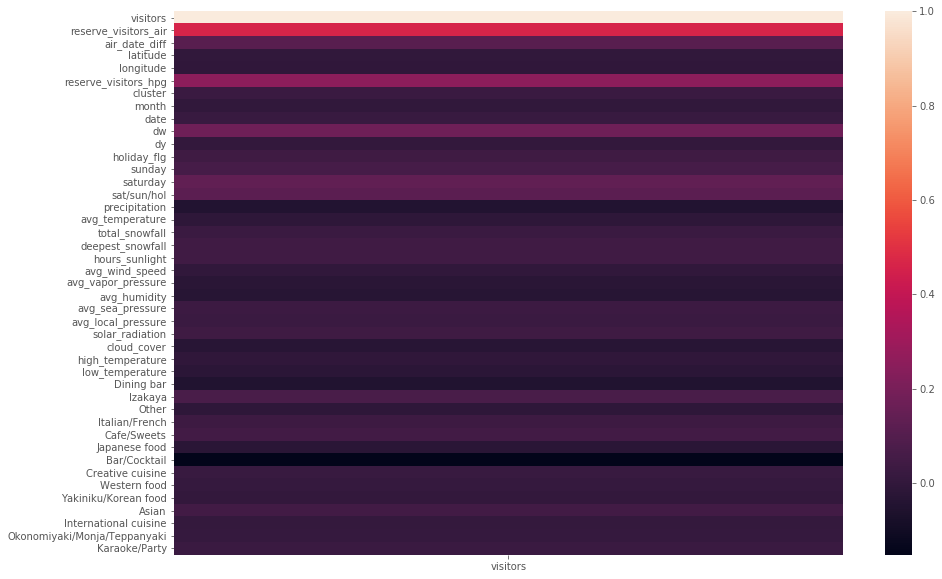

In [80]:
f,axa = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(copyTest.corr()[['visitors']])

In [81]:
#f,axa = plt.subplots(1,1,figsize=(15,10))
#sns.heatmap(wnf.corr()[['visitors']])

<a id='cluster-one-hat-code-cell'> 1.2. One Hat Encoding <code>cluster</code></a>

In [82]:
copyTest['cluster'] = copyTest['cluster'].astype('category')
our_hat_code(copyTest,'cluster')

[0, 3, 2, 7, 4, 1, 5, 6]
8


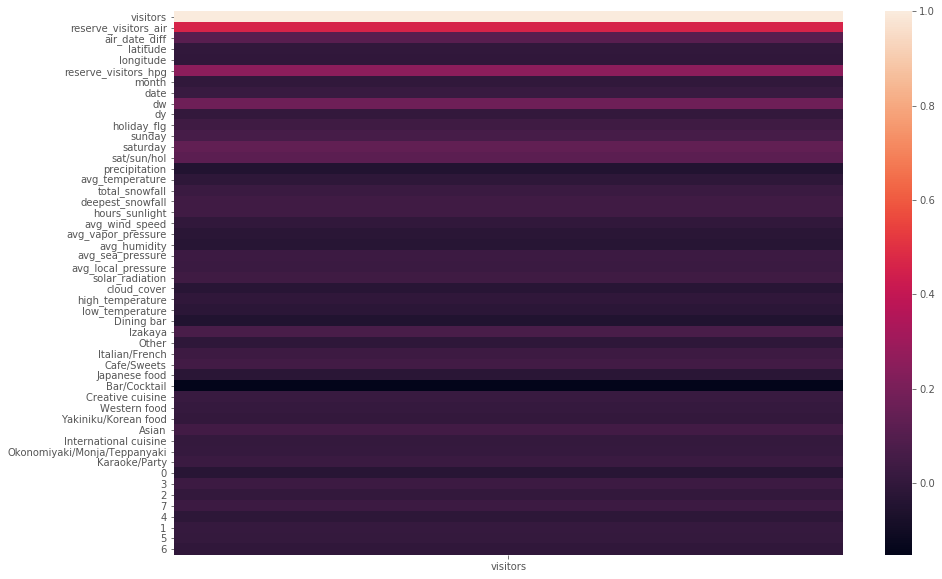

In [83]:
f,axa = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(copyTest.corr()[['visitors']])

In [84]:
copyTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 57 columns):
air_store_id                    252108 non-null object
visit_date                      252108 non-null object
visitors                        252108 non-null int64
reserve_visitors_air            28064 non-null float64
air_date_diff                   28064 non-null float64
air_genre_name                  252108 non-null object
latitude                        252108 non-null float64
longitude                       252108 non-null float64
reserve_visitors_hpg            13550 non-null float64
cluster                         252108 non-null category
prefecture                      252108 non-null object
month                           252108 non-null int64
date                            252108 non-null int64
dw                              252108 non-null int64
dy                              252108 non-null int64
day_of_week                     252108 non-null object
holiday_fl